# Predicting Credit Risk

## Importing Libraries and Dataset

In [34]:
# Importing Librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Importing Datasets
df_credit=pd.read_csv('german_credit_with_risk.csv')
# Plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
py.init_notebook_mode(connected=True)

## Exploratory Data Analysis

### Understanding the data

#### Looking at the type of Data

In [ ]:
print(df_credit.info())
print(df_credit.nunique())

In [36]:
trace0=go.Bar(
    x=df_credit[df_credit["Risk"]=='good']["Risk"].value_counts().index.values,
    y=df_credit[df_credit['Risk']=='good']['Risk'].value_counts().values,
    name="Good Credit"
             )
trace1=go.Bar(
    x=df_credit[df_credit["Risk"]=='bad']["Risk"].value_counts().index.values,
    y=df_credit[df_credit['Risk']=='bad']['Risk'].value_counts().values,
    name="bad Credit"
             )
data=[trace0,trace1]
layout=go.Layout(yaxis=dict(title='Count'),xaxis=dict(title='Risk Variable'),title='Target Variable Distribution')
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='grouped-bar')

## Correlation

In [40]:
pd.crosstab(df_credit['Checking account'],df_credit['Sex'])

Sex,female,male
Checking account,,
little,88,186
moderate,86,183
rich,20,43


In [43]:
cm=sns.light_palette('green',as_cmap=True)
pd.crosstab(df_credit['Purpose'],df_credit['Sex']).style.background_gradient(cmap=cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


### One-hot encoding

In [58]:
# def one_hot_encoder(df,nan_as_category=False): # missing values are ignored during dummy cDeprecationWarning
#     original_columns=list(df.columns)
#     catergorical_columns=[col for col in df.columns if df[col].dtype=='object']
#     df=pd.get_dummies(df, columns=catergorical_columns,dummy_na=nan_as_category,drop_first=True)
#     new_columns=[c for c in df.columns if c not in original_columns]
#     return df, new_columns

In [59]:
import pandas as pd

def robust_one_hot_encoder(df, nan_as_category=False, fill_na_value='no_inf'):
    # Make a copy to avoid modifying original
    df = df.copy()
# Store original columns
    original_columns = list(df.columns)
    # Find categorical columns (object type)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Handle missing values in categorical columns
    if not nan_as_category:
        for col in categorical_columns:
            if df[col].isnull().any():
                df[col] = df[col].fillna(fill_na_value)
                print(f"Filled {df[col].isnull().sum()} NaN values in '{col}' with '{fill_na_value}'")
    # Apply one-hot encoding
    if categorical_columns:
        df = pd.get_dummies(df, 
                          columns=categorical_columns, 
                          dummy_na=nan_as_category, 
                          drop_first=True)
        print(f"Applied one-hot encoding to columns: {categorical_columns}")
    else:
        print("No categorical columns found for encoding")
    
    # Get new column names
    new_columns = [col for col in df.columns if col not in original_columns]
    
    print(f"Created {len(new_columns)} new columns")
    print(f"DataFrame shape: {df.shape}")
    
    return df, new_columns

# Apply to your dataframe
df_credit, new_columns = robust_one_hot_encoder(df_credit)
print("\nEncoding completed successfully!")
df_credit.info()

No categorical columns found for encoding
Created 0 new columns
DataFrame shape: (1000, 22)

Encoding completed successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Age                          1000 non-null   int64
 1   Job                          1000 non-null   int64
 2   Credit amount                1000 non-null   int64
 3   Duration                     1000 non-null   int64
 4   Sex_male                     1000 non-null   bool 
 5   Housing_own                  1000 non-null   bool 
 6   Housing_rent                 1000 non-null   bool 
 7   Saving accounts_moderate     1000 non-null   bool 
 8   Saving accounts_no_inf       1000 non-null   bool 
 9   Saving accounts_quite rich   1000 non-null   bool 
 10  Saving accounts_rich         1000 non-null   bool 
 11  Checking account_moderate    1000 n

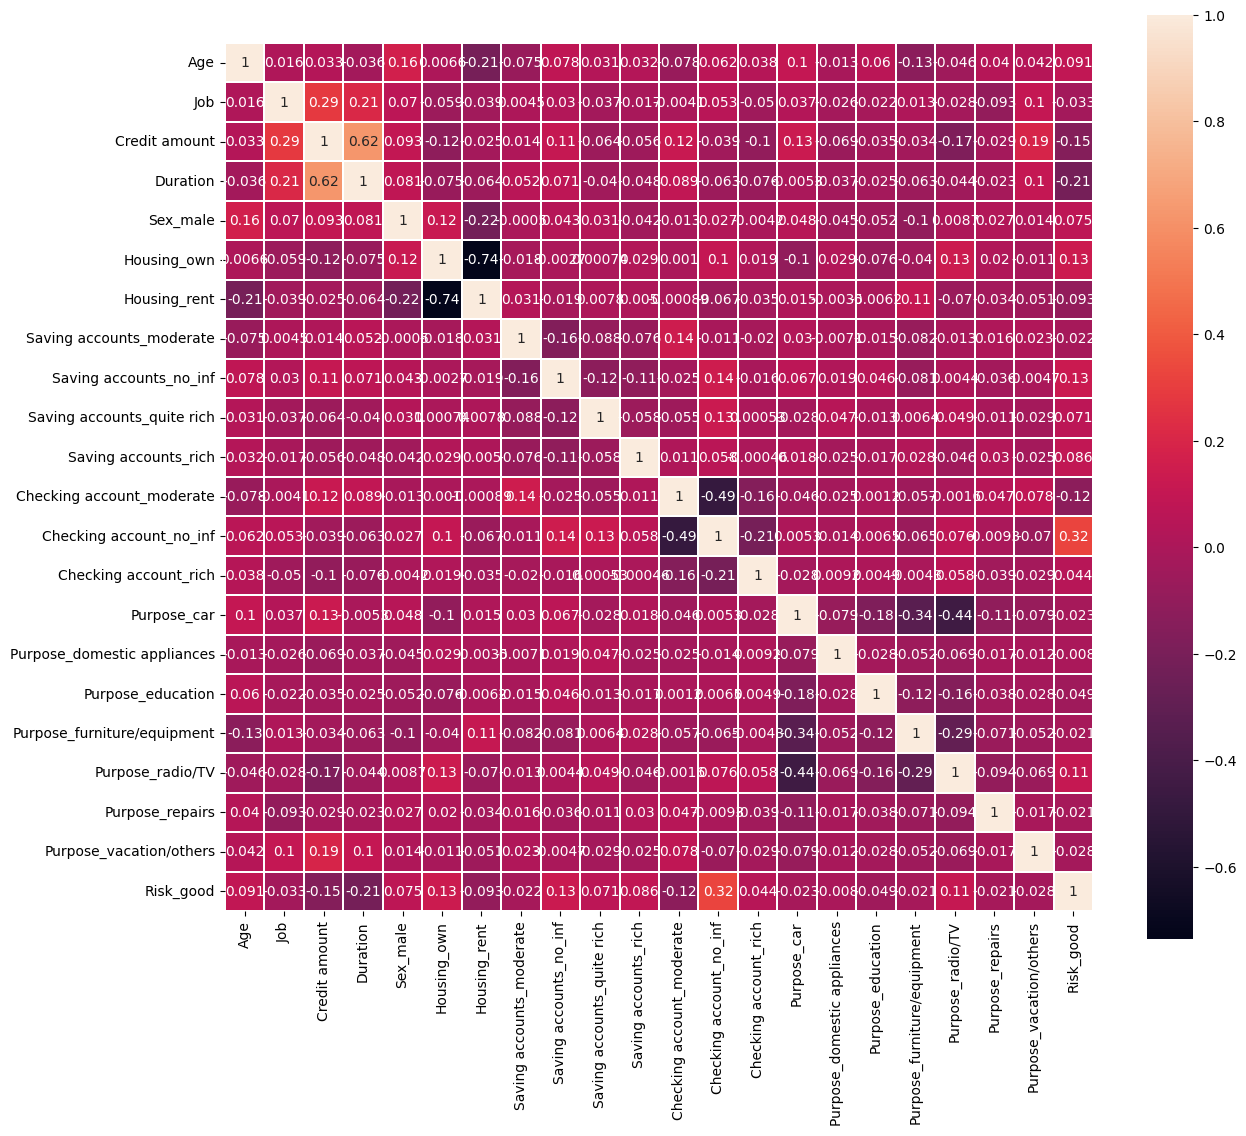

In [63]:
plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white',annot=True)
plt.show()

## Model Comparison

### Preprocessing

In [96]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
# Algorithms to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import sklearn.pipeline as Pipeline
from sklearn.preprocessing import StandardScaler

#### Creating X and y variables

In [86]:
df_credit['Credit amount']=np.log(df_credit['Credit amount'])
X=df_credit.drop('Risk_good',axis=1).values
y=df_credit["Risk_good"]

#### Train Test split

In [88]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

#### Comparing Models

In [110]:
seed=7
models=[]
models.append(("LR",LogisticRegression(max_iter=1000)))
models.append(("LDA",LinearDiscriminantAnalysis()))
models.append(("KNN",KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('RF',RandomForestClassifier()))
models.append(('SVV',SVC(gamma='auto')))
models.append(('XGB',XGBClassifier()))

results=[]
names=[]
scoring='accuracy'
for name, model in models:
    kfold=KFold(n_splits=10,shuffle=True,random_state=seed)
    cv_results=cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg="%s: %f(%f)" %(name,cv_results.mean(),cv_results.std())
    print(msg)

LR: 0.742667(0.039576)
LDA: 0.748000(0.041074)
KNN: 0.670667(0.049907)
CART: 0.662667(0.063958)
NB: 0.696000(0.033092)
RF: 0.745333(0.026965)
SVV: 0.689333(0.039124)
XGB: 0.732000(0.037452)


<function matplotlib.pyplot.show(close=None, block=None)>

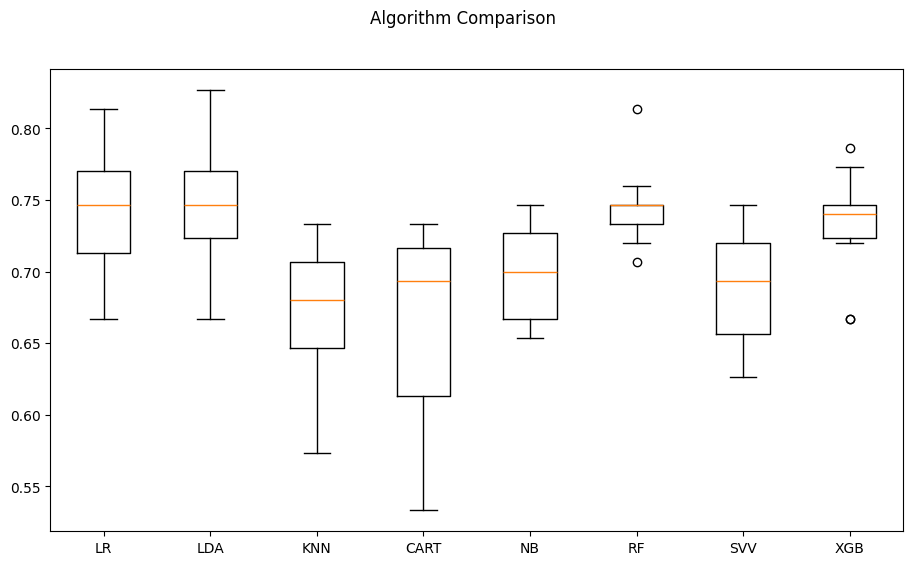

In [111]:
# boxplot algorithm comparison
fig=plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show